Fraction of functional isoforms for novel compared to alternative and reference isoforms

- Try remaking PPI pie chart with only pairs from the screens tested? 

In [27]:
from matplotlib import pyplot as plt
import pandas as pd

from data_loading import (load_valid_isoform_clones,
                          load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data)

In [2]:
iso = load_valid_isoform_clones()
iso['is_longest_isoform'] = iso['clone_acc'].isin(iso.sort_values('num_aa', ascending=False).groupby('gene').nth(0)['clone_acc'].values)
iso['category'] = 'alternative'
iso.loc[iso['is_longest_isoform'], 'category'] = 'reference'
iso.loc[iso['is_novel_isoform'], 'category'] = 'novel'
ppi = load_isoform_and_paralog_y2h_data()
ppi = ppi.loc[ppi['category'] == 'tf_isoform_ppis', :]
pdi = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
iso['valid_ppi_test'] = iso['clone_acc'].map(ppi.groupby('ad_clone_acc').apply(lambda rows: ((rows['score'] == '1') |
                                                                                             (rows['score'] == '0'))
                                                                                             .any()))
iso['at_least_one_ppi'] = iso['clone_acc'].map(ppi.groupby('ad_clone_acc').apply(lambda rows: (rows['score'] == '1')
                                                                                               .any()))
pdi = pdi.drop_duplicates('unique_acc')
iso['at_least_one_pdi'] = iso['clone_acc'].map(pdi.drop(columns=['tf']).set_index('unique_acc').sum(axis=1) > 0)
iso['at_least_two_fold_activation'] = iso['clone_acc'].map(
                                            m1h.drop(columns=['gene'])
                                                .set_index('clone_acc')
                                                .mean(axis=1)
                                                .abs() > 1)

In [14]:
iso.category.value_counts()

alternative    304
reference      267
novel          191
Name: category, dtype: int64

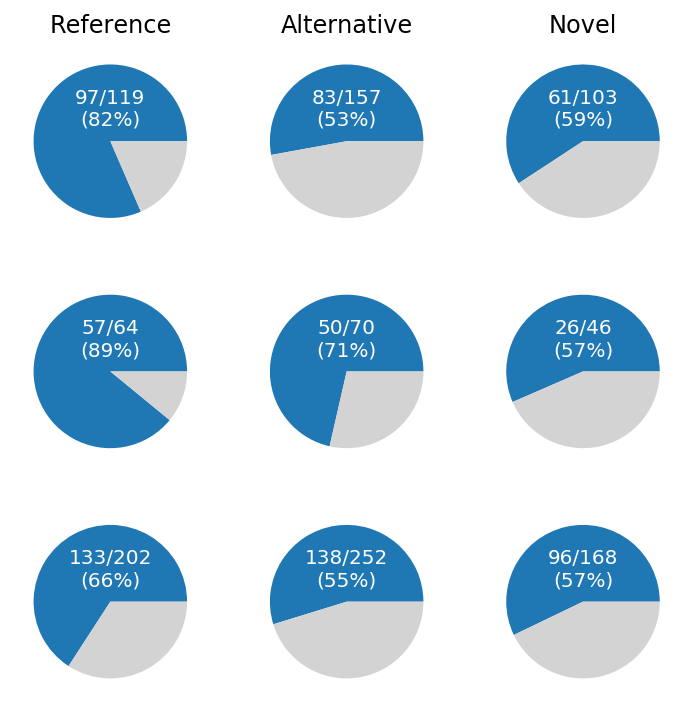

In [89]:
# add numbers and percentage
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(6, 6)
cats = ['reference', 'alternative', 'novel']
for cat, ax in zip(cats, axes[0, :]):
    ax.set_title(cat.capitalize())
    cnt = (iso.loc[iso['valid_ppi_test'] & (iso['category'] == cat),
           'at_least_one_ppi']
       .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[1, :]):
    cnt = (iso.loc[(iso['category'] == cat),
           'at_least_one_pdi']
       .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[2, :]):
    cnt = (iso.loc[(iso['category'] == cat),
           'at_least_two_fold_activation']
       .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
plt.savefig('../figures/fraction_positive_by_isoform_type.pdf',
            bbox_inches='tight')

In [86]:
from scipy import stats

stats.fisher_exact([[50, 20], [26, 20]])

(1.9230769230769231, 0.1131808510997808)

In [90]:
# look at PPI OR PDI OR M1H?
iso.head()

,gene,clone_acc,aa_seq,num_aa,is_novel_isoform,is_longest_isoform,category,valid_ppi_test,at_least_one_ppi,at_least_one_pdi,at_least_two_fold_activation
0,AEBP2,AEBP2|2/3|05F03,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,268,True,True,novel,NaN,NaN,NaN,False
1,AEBP2,AEBP2|3/3|05E07,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,263,True,False,novel,NaN,NaN,NaN,False
2,ARNT2,ARNT2|1/6|08C12,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,717,False,True,reference,True,True,NaN,True
3,ARNT2,ARNT2|2/6|09E01,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,683,True,False,novel,True,True,NaN,True
4,ARNT2,ARNT2|3/6|10D11,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,716,False,False,alternative,False,False,NaN,NaN


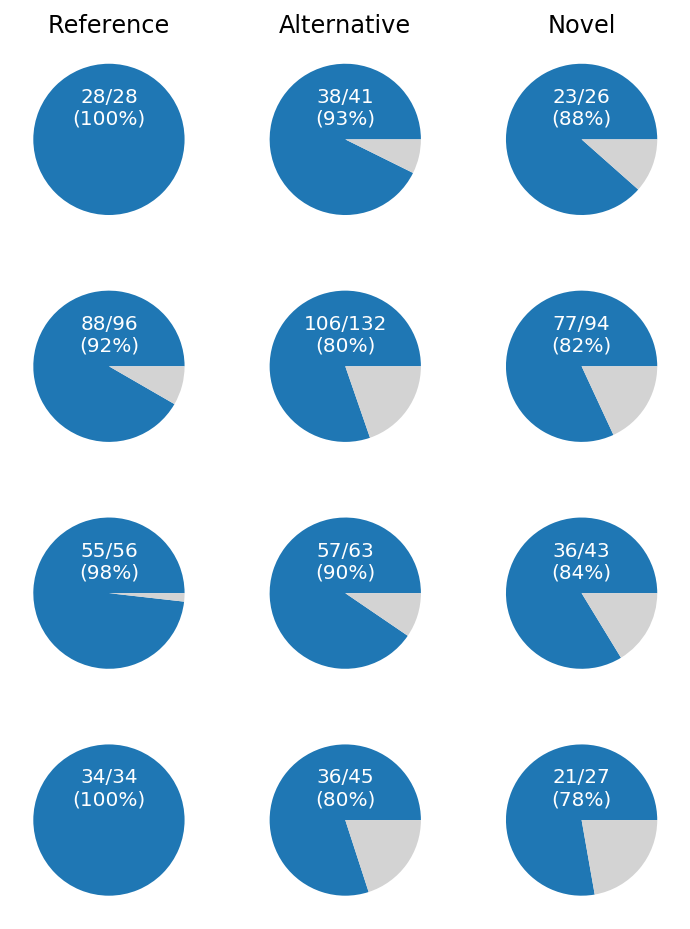

In [94]:
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(6, 8)
cats = ['reference', 'alternative', 'novel']
for cat, ax in zip(cats, axes[0, :]):
    ax.set_title(cat.capitalize())
    tested_iso = (iso['valid_ppi_test'] & 
                  iso['at_least_two_fold_activation'].notnull() &
                  iso['at_least_one_pdi'].notnull() &
                  (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_ppi'] |
            iso.loc[tested_iso, 'at_least_two_fold_activation'] |
            iso.loc[tested_iso, 'at_least_one_pdi']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[1, :]):
    tested_iso = (iso['valid_ppi_test'] & 
                    iso['at_least_two_fold_activation'].notnull() &
                    (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_ppi'] | iso.loc[tested_iso, 'at_least_two_fold_activation']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[2, :]):
    tested_iso = (iso['at_least_one_pdi'].notnull() & 
                    iso['at_least_two_fold_activation'].notnull() &
                    (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_pdi'] | iso.loc[tested_iso, 'at_least_two_fold_activation']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[3, :]):
    tested_iso = (iso['at_least_one_pdi'].notnull() & 
                    iso['valid_ppi_test'] &
                    (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_pdi'] | iso.loc[tested_iso, 'at_least_one_ppi']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
plt.savefig('../figures/fraction_positive_by_isoform_type_this_or_that.pdf',
            bbox_inches='tight')

## kaia's new plots